# Flash ID validation 
Jupyter notebook to look at a PMT based neutrino ID for the LEE searches

## Imports

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import matplotlib.patches as patches
from matplotlib import colors
from matplotlib.colors import LogNorm
import helpfunction as helper
from matplotlib.ticker import MaxNLocator
from labellines import labelLines

pd.set_option('display.max_columns', 500)

In [3]:
%autoreload

## Constants

In [4]:
gr = 1.618
outdir= './output/FlashID/'
inputdir = './input/ImprovedMay/run3/'  

mc_start = 3.16
bnb_start = mc_start + 2*0.015625
ext_start = mc_start + 26*0.015625
intime_start = 3.57
duration = 1.68
nrPMT = 32
rangePMT = range(nrPMT)

mass_mu = 0.106
kin_min = 0.02
kin_min_mu = kin_min + mass_mu

sig = 'nue'

In [5]:
dict_names = ['nue','nu','on','off','dirt']

main_tree_name= 'pandoraSliceId'
shift_time = [0,0,0.03,0.42]          # fullmc
shift_time = [0.0,0.0,-0.375,0.0, 0.0] # overlay+dirt

lower = [-1.55, -115.53, 0.1]
upper = [254.8, 117.47, 1036.9]
fidvol_arr = [10,10,10,10,10,50] 

## Definitions

In [6]:
def inTPC(row):
    if 0 < row['_nu_vtx_x'] < 256.35:
        if 0 < row['_nu_vtx_z'] < 1036.8:
            if -116.5 < row['_nu_vtx_y'] < 116.5:
                return True
    return False   

def inTPC_mask(df, str_x, str_y, str_z, fidvol=[0]*6):
    global upper, lower
    mask_x = df[str_x].between(lower[0]+fidvol[0], upper[0]-fidvol[1])
    mask_y = df[str_y].between(lower[1]+fidvol[2], upper[1]-fidvol[3])
    mask_z = df[str_z].between(lower[2]+fidvol[4], upper[2]-fidvol[5])
    mask = mask_x & mask_y & mask_z
    return mask

def inTPC_df(df, str_x, str_y, str_z, fidvol=[0]*6):
    mask = inTPC_mask(df, str_x, str_y, str_z, fidvol)
    return df[mask]

def eventHash(df):
    return df.apply(lambda x: hash(tuple(x)), axis = 1)

## Loading inputs

In [7]:
file_dict = {}
nuecc_dict = {}
first=True

flist =  os.listdir(inputdir)
for sample in dict_names:
    file_name = next((s for s in flist if "NueCC_"+sample in s), None)
    file_dict[sample] = uproot.open(inputdir+file_name)[main_tree_name]
    nuecc_dict[sample] = uproot.open(inputdir+file_name)['nueCCAnalyser']
    
    if first:
        print("----- Optical Selection Tree -----\n")
        for tree_name in file_dict[sample].keys():
            name = tree_name.decode('UTF-8').split(';')[0]
            print('*** ', name, ' ***')
            print(file_dict[sample][tree_name].keys())
            print()
            
        print("\n----- NueCC Tree -----\n")
        for tree_name in nuecc_dict[sample].keys():
            name = tree_name.decode('UTF-8').split(';')[0]
            print('*** ', name, ' ***')
            print(nuecc_dict[sample][tree_name].keys())
            print()
        first = False
        
    print('Loaded',sample, 'sample:', len(file_dict[sample]['events'][b'event']))

----- Optical Selection Tree -----

***  metadata  ***
[b'beamWindowStart', b'beamWindowEnd', b'minBeamFlashPE', b'maxDeltaY', b'maxDeltaZ', b'maxDeltaYSigma', b'maxDeltaZSigma', b'minChargeToLightRatio', b'maxChargeToLightRatio', b'chargeToNPhotonsTrack', b'chargeToNPhotonsShower', b'PMTChannelCorrection']

***  events  ***
[b'run', b'subRun', b'event', b'evt_time_sec', b'evt_time_nsec', b'nFlashes', b'nFlashesInBeamWindow', b'hasBeamFlash', b'nSlices', b'nSlicesAfterPrecuts', b'foundATargetSlice', b'targetSliceMethod', b'bestCosmicMatch', b'cosmicMatchHypothesis', b'nuInteractionType', b'nuCCNC', b'nuEnergy', b'leptonEnergy', b'nuInteractionTime', b'nuPdgCode', b'nuVertexX', b'nuVertexY', b'nuVertexZ']

***  flashes  ***
[b'run', b'subRun', b'event', b'evt_time_sec', b'evt_time_nsec', b'time', b'centerY', b'centerZ', b'widthY', b'widthZ', b'totalPE', b'peSpectrum', b'inBeamWindow', b'isBrightestInWindow', b'isBeamFlash']

***  slices  ***
[b'sliceId', b'run', b'subRun', b'event', b'e

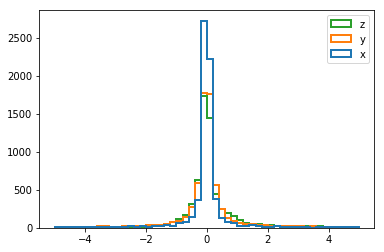

In [8]:
nue_complete_mask = (file_dict['nue']['slices'].array('completeness')>0.5 )[file_dict['nue']['slices'].array('isTaggedAsTarget')]

dx = (nuecc_dict['nue']['Event'].array('nu_vx') - nuecc_dict['nue']['Event'].array('mc_nu_vx_sce'))[nue_complete_mask]
dy = (nuecc_dict['nue']['Event'].array('nu_vy') - nuecc_dict['nue']['Event'].array('mc_nu_vy_sce'))[nue_complete_mask]
dz = (nuecc_dict['nue']['Event'].array('nu_vz') - nuecc_dict['nue']['Event'].array('mc_nu_vz_sce'))[nue_complete_mask]

plt.hist([dx,dy,dz], histtype='step', range=(-5,5), bins=50, label=['x','y','z'], lw=2)
plt.legend()

## Quick checks

In [9]:
# Get the POT from the MC samples
pot_nue = sum(nuecc_dict['nue']['subruns'].array('pot'))
print('Total POT in nue file: {0:.4g}'.format(pot_nue))
pot_nu = sum(nuecc_dict['nu']['subruns'].array('pot'))
print('Total POT in nu file: {0:.4g}'.format(pot_nu))
pot_dirt = sum(nuecc_dict['dirt']['subruns'].array('pot'))
print('Total POT in dirt file: {0:.4g}'.format(pot_dirt))

Total POT in nue file: 4.866e+21
Total POT in nu file: 1.185e+19
Total POT in dirt file: 1.049e+20


In [10]:
if 1: # Only run once if you dont know the number of pot and triggers yet
    # Get the run subrun list from data samples
    samples = ['on', 'off']
    for sample in samples:
        out_name = outdir + 'run_subrun_' + sample + '.txt'
        run_subrun = np.array(nuecc_dict[sample]['subruns'].arrays(['run', 'subRun'], outputtype=pd.DataFrame))
        np.savetxt(out_name, run_subrun, fmt='%d')

triggers_off = 5579116 #37207065 #5579116.0 #15060902.0 # 23503629.0 (sample as production)
triggers_on = 359537 #9973872 #359537.0 #10701086.0
pot_on = 1.54e+18 #4.495e+19 # 4.54e+19 (sample as production)
title_str = "MicroBooNE {0:.2g} POT, INTERNAL".format(pot_on)

scale_off = triggers_on / triggers_off
scale_nu = pot_on / pot_nu
scale_nue = pot_on / pot_nue
scale_dirt = pot_on / pot_dirt
scale_on = 1

scales = [scale_nue, scale_nu, scale_on, scale_off, scale_dirt]
print(scales)

[0.0003164940068271165, 0.129954152163159, 1, 0.06444336342890164, 0.014681071147538402]


In [11]:
# For all events
sample = sig
data = file_dict[sample]['events'].array('nFlashesInBeamWindow')
print('Events with flash in window: {0:.2f}%'.format(sum(data)/len(data)*100))
data = file_dict[sample]['events'].array('hasBeamFlash')
print('Events with flash in window and 50PE: {0:.2f}%'.format(sum(data)/len(data)*100))
nom = file_dict[sample]['events'].array('nSlicesAfterPrecuts')>0 
denom2 = file_dict[sample]['events'].array('nSlices')
print('Events passing the precuts: {0:.1f}%'.format(sum(nom)/len(denom2)*100))

denom = (file_dict[sample]['slices'].array('completeness') > 0.8) & (file_dict[sample]['slices'].array('purity') > 0.8)
nom = (file_dict[sample]['slices'].array('isTaggedAsTarget'))


print('Selected slice is purity and complete slice (opt sel performance metric): {0:.1f}%'.format(sum(nom & denom)/sum(denom)*100))
print('Percentage of events with a complete/pure neutrino slice: {0:.1f}%'.format(sum(denom)/len(denom2)*100))

Events with flash in window: 98.01%
Events with flash in window and 50PE: 97.95%
Events passing the precuts: 83.3%
Selected slice is purity and complete slice (opt sel performance metric): 85.8%
Percentage of events with a complete/pure neutrino slice: 64.2%


In [12]:
slice_cols = ['run', 'subRun', 'event', 'evt_time_sec', 'evt_time_nsec', 
              'hasDeposition', 'totalCharge', 'centerX', 'centerY', 'centerZ', 
              'deltaY', 'deltaZ', 'deltaYSigma', 'deltaZSigma', 'chargeToLightRatio', 'xclVariable', 
              'passesPreCuts', 'flashMatchScore', 'isTaggedAsTarget', 
              'targetMethod', 'isConsideredByFlashId', 'topologicalScore', 'hasBestTopologicalScore', 'hasBestFlashMatchScore', 
              'nHits', 'purity', 'completeness', 'isMostComplete', 'nuCCNC', 'nuEnergy', 'leptonEnergy', 'nuPdgCode', 
              'nuVertexX', 'nuVertexY', 'nuVertexZ']

In [13]:
# Signal if the true vertex is inside the fiducial volume and the lepton has more than 20MeV kinetic energy
df_nue_sig = inTPC_df( file_dict['nue']['events'].pandas.df(flatten=False), 'nuVertexX', 'nuVertexY', 'nuVertexZ', fidvol=fidvol_arr)
df_nue_sig = df_nue_sig.query('leptonEnergy>@kin_min') # & nuEnergy<0.6') 
df_nu_sig = inTPC_df( file_dict['nu']['events'].pandas.df(flatten=False), 'nuVertexX', 'nuVertexY', 'nuVertexZ', fidvol=fidvol_arr)
df_nu_sig = df_nu_sig.query('leptonEnergy>@kin_min_mu & nuCCNC==0 & abs(nuPdgCode)==14')

# First, construct signal frame!
df_nue_slices_sig = inTPC_df( file_dict['nue']['slices'].pandas.df(slice_cols), 'nuVertexX', 'nuVertexY', 'nuVertexZ', fidvol=fidvol_arr)
df_nue_slices_sig = df_nue_slices_sig.query('leptonEnergy>@kin_min') #  & nuEnergy<0.6')
df_nu_slices_sig = inTPC_df( file_dict['nu']['slices'].pandas.df(slice_cols), 'nuVertexX', 'nuVertexY', 'nuVertexZ', fidvol=fidvol_arr)
df_nu_slices_sig = df_nu_slices_sig.query('leptonEnergy>@kin_min_mu & ~nuCCNC & abs(nuPdgCode)==14')

if sig=='nu':
    df_slices_sig = df_nu_slices_sig
    df_sig = df_nu_sig
elif sig=='nue':
    df_slices_sig = df_nue_slices_sig
    df_sig = df_nue_sig
else:
    print('What is the signal sample? ERROR!')

In [14]:
df_slices_sig.head()

,run,subRun,event,evt_time_sec,evt_time_nsec,hasDeposition,totalCharge,centerX,centerY,centerZ,deltaY,deltaZ,deltaYSigma,deltaZSigma,chargeToLightRatio,xclVariable,passesPreCuts,flashMatchScore,isTaggedAsTarget,targetMethod,isConsideredByFlashId,topologicalScore,hasBestTopologicalScore,hasBestFlashMatchScore,nHits,purity,completeness,isMostComplete,nuCCNC,nuEnergy,leptonEnergy,nuPdgCode,nuVertexX,nuVertexY,nuVertexZ
4,17452,16,807,1530156574,787379000,True,196646.937500,134.565506,-58.052021,387.758362,-62.513809,-9.166931,-1.278556,-0.053459,56.711945,338.926636,True,115.127678,True,0,True,0.999669,True,True,3214,0.981643,0.895798,True,0,2.901734,2.37409,12,143.593155,-64.711067,327.462463
5,17452,16,807,1530156574,787379000,True,94651.828125,138.088608,67.571800,691.305054,63.110012,294.379761,1.290750,1.716747,27.297091,249.662796,False,135.887054,False,-2147483647,True,0.031118,False,False,3175,0.051024,0.045997,False,0,2.901734,2.37409,12,143.593155,-64.711067,327.462463
6,17452,16,807,1530156574,787379000,True,38601.933594,178.965805,36.475643,927.782410,32.013855,530.857117,0.654760,3.095822,11.132595,103.615219,False,125.571602,False,-2147483647,True,0.017587,False,False,1019,0.000000,0.000000,False,0,2.901734,2.37409,12,143.593155,-64.711067,327.462463
7,17452,16,807,1530156574,787379000,True,8982.366211,81.070496,-71.775826,2.390319,-76.237617,-394.534973,-1.559241,-2.300827,2.590467,30.541595,False,119.315163,False,-2147483647,True,0.032663,False,False,202,0.000000,0.000000,False,0,2.901734,2.37409,12,143.593155,-64.711067,327.462463
8,17452,16,807,1530156574,787379000,True,15904.094727,218.749634,-99.739532,26.970016,-104.201324,-369.955261,-2.131165,-2.157484,4.586658,-40.145615,False,118.692924,False,-2147483647,True,0.062556,False,False,330,0.000000,0.000000,False,0,2.901734,2.37409,12,143.593155,-64.711067,327.462463


In [15]:
num_sig = len(df_sig.index)
frq = sum(df_sig['nFlashesInBeamWindow'])/num_sig
err = helper.effErr(sum(df_sig['nFlashesInBeamWindow']), num_sig)
print('Events with flash in window: ({0:.2f}+-{1:.2f})%'.format(frq*100,err*100))
frq = sum(df_sig['hasBeamFlash'])/num_sig
err = helper.effErr(sum(df_sig['hasBeamFlash']), num_sig)
print('Events with 50PE flash in window: ({0:.2f}+-{1:.2f})%'.format(frq*100,err*100))
frq = sum(df_sig['nSlicesAfterPrecuts']>0)/num_sig
err = helper.effErr(sum(df_sig['nSlicesAfterPrecuts']>0), num_sig)
print('Events passing optical selection: ({0:.2f}+-{1:.2f})%'.format(frq*100,err*100))

Events with flash in window: (98.41+-0.14)%
Events with 50PE flash in window: (98.40+-0.14)%
Events passing optical selection: (88.16+-0.36)%


In [16]:
mask = df_slices_sig.eval('isTaggedAsTarget & isMostComplete')
frq = sum(mask)/num_sig
err = helper.effErr(sum(mask), num_sig)
print('Events where most complete slice passes the optical selection: ({0:.2f}+-{1:.2f})%'.format(frq*100,err*100))

mask = df_slices_sig.eval('isTaggedAsTarget & completeness>0.8 & purity>0.8')
mask_denom = df_slices_sig.eval('completeness>0.8 & purity>0.8')
frq = sum(mask)/sum(mask_denom)
err = helper.effErr(sum(mask), sum(mask_denom))
print('80%+Pure/Complete slices passing the selection: ({0:.2f}+-{1:.2f})%'.format(frq*100,err*100))


Events where most complete slice passes the optical selection: (83.56+-0.41)%
80%+Pure/Complete slices passing the selection: (90.31+-0.41)%


In [17]:
samples = ["off", "on", 'nue', 'nu', "dirt"]

for sample in samples:
    if sample in file_dict:
        passf = file_dict[sample]['events'].array('nSlicesAfterPrecuts')>0
        print("Percentage of events passing in BNB",sample,": {0:.1f}%".format(sum(passf)*100/len(passf)))

Percentage of events passing in BNB off : 20.6%
Percentage of events passing in BNB on : 27.1%
Percentage of events passing in BNB nue : 83.3%
Percentage of events passing in BNB nu : 47.3%
Percentage of events passing in BNB dirt : 27.6%


In [18]:
#Data/MC before selection
mc_num = file_dict['nu']['events'].numentries*scale_nu + file_dict['dirt']['events'].numentries*scale_dirt + file_dict['off']['events'].numentries*scale_off
print(file_dict['on']['events'].numentries*scale_on / mc_num)
#Data/MC after selection
mc_num = nuecc_dict['nu']['Event'].numentries*scale_nu + nuecc_dict['dirt']['Event'].numentries*scale_dirt + nuecc_dict['off']['Event'].numentries*scale_off
print(nuecc_dict['on']['Event'].numentries*scale_on / mc_num)

1.0380020769081377
1.014949888425045


## Flash plots

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


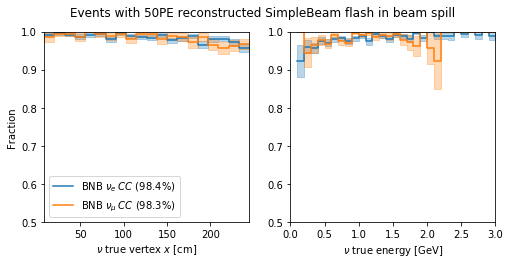

In [19]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,3.5))
fig.suptitle('Events with 50PE reconstructed SimpleBeam flash in beam spill')

# Left
x_min = lower[0]+fidvol_arr[0]
x_max = upper[0]-fidvol_arr[1]
N = 21
edges = np.linspace(x_min,x_max,N)
nom_bins, _ = np.histogram(df_nue_sig.query('hasBeamFlash')['nuVertexX'], bins=edges)
denom_bins, _ = np.histogram(df_nue_sig['nuVertexX'], bins=edges)
fraq = nom_bins/denom_bins
err = np.sqrt( fraq*(1-fraq)/denom_bins )
fraq=np.append(fraq,fraq[-1])
err=np.append(err,err[-1])
ratio = sum(nom_bins)/sum(denom_bins)
ax[0].step(edges, fraq, where='post',  label = r'BNB $\nu_e \: CC$ ({0:.1f}%)'.format(ratio*100))
ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C0')

nom_bins, _ = np.histogram(df_nu_sig.query('hasBeamFlash')['nuVertexX'], bins=edges)
denom_bins, _ = np.histogram(df_nu_sig['nuVertexX'], bins=edges)
fraq = nom_bins/denom_bins
err = np.sqrt( fraq*(1-fraq)/denom_bins )
fraq=np.append(fraq,fraq[-1])
err=np.append(err,err[-1])
ratio = sum(nom_bins)/sum(denom_bins)
ax[0].step(edges, fraq, where='post', label = r'BNB $\nu_\mu \: CC$ ({0:.1f}%)'.format(ratio*100))
ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C1')

ax[0].legend()
ax[0].set_ylabel('Fraction')
ax[0].set_ylim(0.5,1)
ax[0].set_xlabel(r'$\nu$ true vertex $x$ [cm]')
ax[0].set_xlim(x_min,x_max)

# Right
x_min = 0
x_max = 3
N = 31
edges = np.linspace(x_min,x_max,N)
nom_bins, _ = np.histogram(df_nue_sig.query('hasBeamFlash')['nuEnergy'], bins=edges)
denom_bins, _ = np.histogram(df_nue_sig['nuEnergy'], bins=edges)
fraq = nom_bins/denom_bins
err = np.sqrt( fraq*(1-fraq)/denom_bins )
fraq=np.append(fraq,fraq[-1])
err=np.append(err,err[-1])
ax[1].step(edges, fraq, where='post')
ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C0')

nom_bins, _ = np.histogram(df_nu_sig.query('hasBeamFlash')['nuEnergy'], bins=edges)
denom_bins, _ = np.histogram(df_nu_sig['nuEnergy'], bins=edges)
fraq = nom_bins/denom_bins
err = np.sqrt( fraq*(1-fraq)/denom_bins )
fraq=np.append(fraq,fraq[-1])
err=np.append(err,err[-1])
ax[1].step(edges, fraq, where='post')
ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C1')

ax[1].set_xlabel(r'$\nu$ true energy [GeV]')
ax[1].set_ylim(0.5,1)
ax[1].set_xticks(np.linspace(x_min,x_max,7))
ax[1].set_xlim(x_min,x_max)

fig.savefig( outdir+"flash_eff.pdf", bbox_inches="tight")

In [20]:
# data/MC ratio events with valid flash:
ratio = file_dict["on"]['events'].numentries / (file_dict["nu"]['events'].numentries*scales[1]+ file_dict["dirt"]['events'].numentries*scales[4] + file_dict["off"]['events'].numentries*scales[3])
print(ratio)
ratio = sum(file_dict["on"]['events'].array('hasBeamFlash')) / (sum(file_dict["nu"]['events'].array('hasBeamFlash'))*scales[1]+ sum(file_dict["dirt"]['events'].array('hasBeamFlash'))*scales[4] + sum(file_dict["off"]['events'].array('hasBeamFlash'))*scales[3])
print(ratio)

frq = sum(file_dict["off"]['events'].array('hasBeamFlash'))/len(file_dict["off"]['events'].array('hasBeamFlash'))
err = helper.effErr(sum(file_dict["off"]['events'].array('hasBeamFlash')),len(file_dict["off"]['events'].array('hasBeamFlash')))
print('Fraction of BNB off events with a flash of at least 50PE in the beam window: ({0:.2f}+-{1:.2f})%'.format(frq*100,err*100))

1.0380020769081377
1.1029621465213124
Fraction of BNB off events with a flash of at least 50PE in the beam window: (67.68+-0.18)%


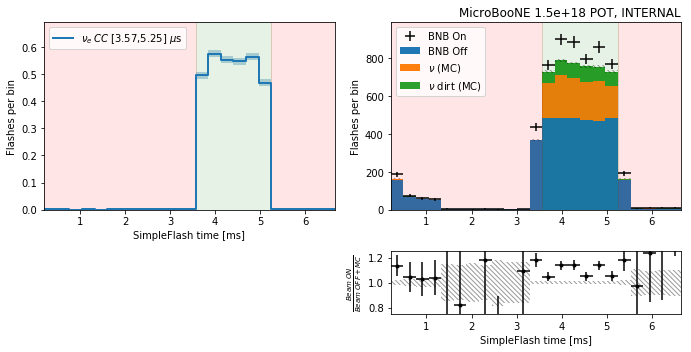

In [21]:
N=23
duration/5
x_min = ext_start-0.28*12
x_max = 0.28*5+ext_start+duration
field = 'time'
lab = 'SimpleFlash time [ms]'
y_r_min = 0.75
y_r_max = 1.25


fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(6*gr,5.), gridspec_kw = {'height_ratios':[3, 1]})

data = [file_dict[s]['flashes'].array(field)-dt for s,dt in zip(dict_names, shift_time)]
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales)
widths = (edges_mid - edges[:-1])

# Nue MC
mean = np.mean(data[0][data[0]>-1])
bins[0]=np.append(bins[0],bins[0][0])
err[0]=np.append(err[0],err[0][0])
ax[0][0].step(edges,bins[0], lw=2, where='post', label=r'$\nu_e \: CC$ [3.57,5.25] $\mu$s'.format(mean))
ax[0][0].fill_between(edges, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='post')
ax[0][0].set_xlim(x_min,x_max)
ax[0][0].set_ylim(0,1.2*max_val[0])
ax[0][0].set_xlabel(lab)
ax[0][0].set_ylabel('Flashes per bin')
ax[0][0].legend()

# Data/MC
ax[0][1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt="none",label="BNB On")
ax[0][1].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
ax[0][1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ (MC)', width = 2*widths, bottom = bins[3])
ax[0][1].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])
y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][1].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

# Ratio plots
ax[1][1].set_ylim(y_r_min,y_r_max)
ax[1][1].set_xlim(x_min,x_max)
ax[1][1].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')

ax[0][1].set_xlim(x_min,x_max)
ax[0][1].legend()
ax[1][1].set_xlabel(lab)
ax[0][1].set_ylabel('Flashes per bin')
ax[0][1].set_title(title_str, loc='right')
ax[0][1].set_ylim(0,1.1*max_val[2])

ax[0][1].axvspan(x_min,ext_start, alpha=0.1, color="red")
ax[0][1].axvspan(ext_start,ext_start+duration, alpha=0.1, color="green")
ax[0][1].axvspan(ext_start+duration,x_max, alpha=0.1, color="red")
ax[0][0].axvspan(x_min,ext_start, alpha=0.1, color="red")
ax[0][0].axvspan(ext_start,ext_start+duration, alpha=0.1, color="green")
ax[0][0].axvspan(ext_start+duration,x_max, alpha=0.1, color="red")

fig.delaxes(ax[1][0])
fig.tight_layout()
fig.savefig(outdir+field+".pdf", bbox_inches="tight")

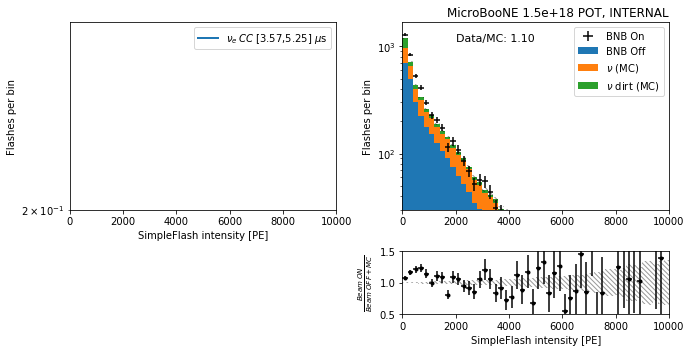

In [22]:
N=50
x_min = 0
x_max = 10000
field = 'totalPE'
lab = 'SimpleFlash intensity [PE]'
y_r_min = 0.5
y_r_max = 1.5

fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(6*gr,5.), gridspec_kw = {'height_ratios':[3, 1]})
masks = [file_dict[s]['flashes'].array('inBeamWindow') for s in dict_names]
data = [file_dict[s]['flashes'].array(field)[m] for s,m in zip(dict_names, masks)]
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales)
widths = (edges_mid - edges[:-1])

# Nue MC
ax[0][1].text(0.2, 0.9, r'Data/MC: {0:0.2f}'.format(ratio), transform=ax[0][1].transAxes, size=11)
mean = np.mean(data[0][data[0]>-1])
bins[0]=np.append(bins[0],bins[0][0])
err[0]=np.append(err[0],err[0][0])
ax[0][0].step(edges,bins[0], lw=2, where='post', label=r'$\nu_e \: CC$ [3.57,5.25] $\mu$s'.format(mean))
ax[0][0].fill_between(edges, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='post')
ax[0][0].set_xlim(x_min,x_max)
ax[0][0].set_ylim(0.2,1.2*max_val[0])
ax[0][0].set_xlabel(lab)
ax[0][0].set_ylabel('Flashes per bin')
ax[0][0].legend()

# Data/MC
ax[0][1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt="none",label="BNB On")
ax[0][1].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
ax[0][1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ (MC)', width = 2*widths, bottom = bins[3])
ax[0][1].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])
y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][1].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

# Ratio plots
ax[1][1].set_ylim(y_r_min,y_r_max)
ax[1][1].set_xlim(x_min,x_max)
ax[1][1].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')

ax[0][1].set_xlim(x_min,x_max)
ax[0][1].legend()
ax[1][1].set_xlabel(lab)
ax[0][1].set_ylabel('Flashes per bin')
ax[0][1].set_title(title_str, loc='right')
ax[0][1].set_ylim(30,1.3*max_val[2])

ax[0][1].set_yscale("log")
ax[0][0].set_yscale("log")

fig.delaxes(ax[1][0])
fig.tight_layout()
fig.savefig(outdir+field+".pdf", bbox_inches="tight")

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


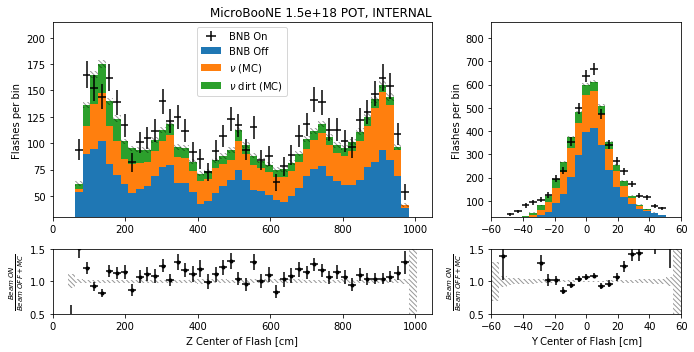

In [23]:
# Flash center 
y_r_min = 0.5
y_r_max = 1.5
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(6*gr,5.), gridspec_kw = {'height_ratios':[3, 1], 'width_ratios':[2, 1]})

N_arr=[50,25]
x_min_arr = [0, -60]
x_max_arr = [1045,60]
field_arr = ['centerZ', 'centerY']
lab_arr = ['Z Center of Flash [cm]', 'Y Center of Flash [cm]']

for i, (x_min, x_max, field, lab, N) in enumerate(zip(x_min_arr, x_max_arr, field_arr, lab_arr, N_arr)):

    masks = [file_dict[s]['flashes'].array('inBeamWindow') for s in dict_names]
    data = [file_dict[s]['flashes'].array(field)[m] for s,m in zip(dict_names, masks)]
    edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales)
    widths = (edges_mid - edges[:-1])


    # Data/MC
    ax[0][i].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt="none",label="BNB On")
    ax[0][i].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
    ax[0][i].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ (MC)', width = 2*widths, bottom = bins[3])
    ax[0][i].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])
    y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
    val = bins[3]+bins[1]+bins[4]
    for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
        ax[0][i].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
        sc_err = e/v
        ax[1][i].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

    # Ratio plots
    ax[1][i].set_ylim(y_r_min,y_r_max)
    ax[1][i].set_xlim(x_min,x_max)
    ax[1][i].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
    ax[1][i].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
    ax[0][i].set_xlim(x_min,x_max)
    ax[1][i].set_xlabel(lab)
    ax[0][i].set_ylabel('Flashes per bin')
    ax[0][i].set_ylim(30,1.3*max_val[2])

ax[0][0].set_title(title_str, loc='right')
ax[0][0].legend()
fig.tight_layout()
fig.savefig(outdir+field+".pdf", bbox_inches="tight")

## Slice plots

In [24]:
# Be careful:
# Nue sample is all inside TPC, nu sample is in full cryostat!

# Split BNB sample in 2 categories:
mask_nu_events = inTPC_mask( file_dict['nu']['events'].pandas.df(['nuVertexX', 'nuVertexY', 'nuVertexZ']), 'nuVertexX', 'nuVertexY', 'nuVertexZ')
mask_nu_slices = inTPC_mask( file_dict['nu']['slices'].pandas.df(['nuVertexX', 'nuVertexY', 'nuVertexZ']), 'nuVertexX', 'nuVertexY', 'nuVertexZ')

In [25]:
print(sum(df_sig['nSlicesAfterPrecuts']>1)/sum(df_sig['nSlicesAfterPrecuts']>0))
print(df_sig['targetSliceMethod'].value_counts()/num_sig)

0.21428571428571427
 0    0.692658
 1    0.164924
-1    0.118436
 2    0.023982
Name: targetSliceMethod, dtype: float64


In [26]:
field_arr = ['nSlices', 'nSlicesAfterPrecuts', 'nFlashes', 'nFlashesInBeamWindow', 'foundATargetSlice']
N_arr = [10,5,4,2,2]
x_min_arr = [-0.5]*5
x_max_arr = [9.5,4.5, 3.5,1.5,1.5]
apply_mask_arr = [1,1,0,0,1]
label_arr = ['Number of slices per event', 'Number of slices after precuts', 'Number of flashes per event', 
             'Number of flashes in spill', 'Tagged as neutrino']

arrays = [field_arr, N_arr, x_min_arr, x_max_arr, label_arr, apply_mask_arr]

[0.0003164940068271165, 0.129954152163159, 1, 0.06444336342890164, 0.014681071147538402, 0.129954152163159]
1.10253262382393
[0.0003164940068271165, 0.129954152163159, 1, 0.06444336342890164, 0.014681071147538402, 0.129954152163159]
1.1029694185144403
[0.0003164940068271165, 0.129954152163159, 1, 0.06444336342890164, 0.014681071147538402, 0.129954152163159]
1.0380020769081377
[0.0003164940068271165, 0.129954152163159, 1, 0.06444336342890164, 0.014681071147538402, 0.129954152163159]
1.0380020769081377
[0.0003164940068271165, 0.129954152163159, 1, 0.06444336342890164, 0.014681071147538402, 0.129954152163159]
1.1029621465213124


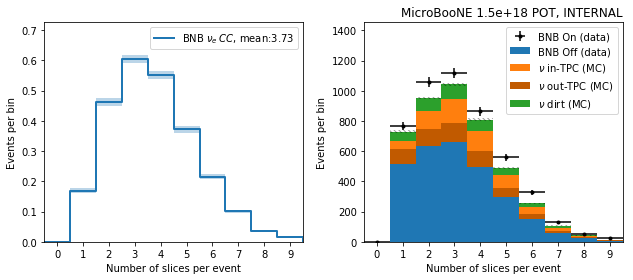

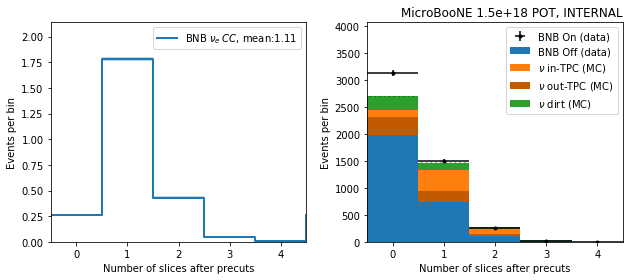

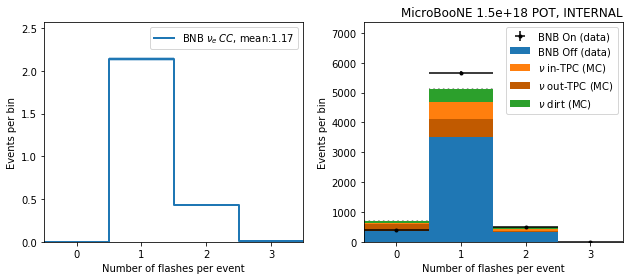

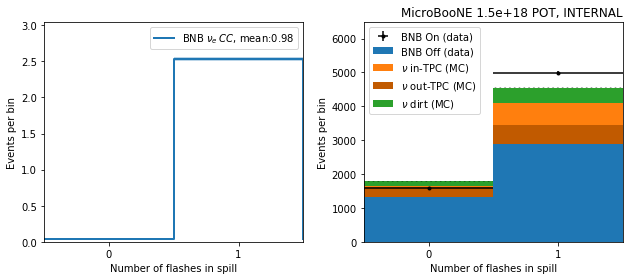

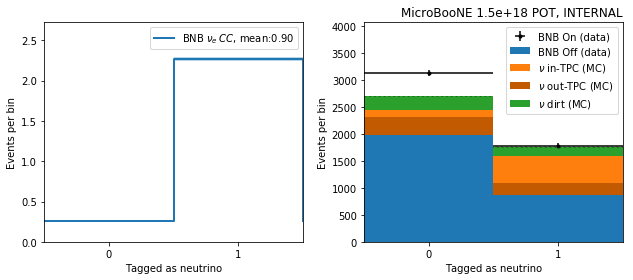

In [27]:
for field, N, x_min, x_max, lab, apply_mask in zip(*arrays):
    
    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5.5*gr,4), sharex=True)
    
    data = [file_dict[s]['events'].array(field) for s in dict_names]
    # I need a signal sample for nue, overwrite it!    
    data[0] = df_sig[field]
    # I need an in-tpc version of the BNB nu sample:
    data.append(data[1][~mask_nu_events])
    scales_here = scales+[scales[1]]
    
    if apply_mask:
        mask = [file_dict[s]['events'].array('hasBeamFlash') for s in dict_names]
        mask[0] = df_sig['hasBeamFlash']
        mask.append(mask[1][~mask_nu_events])
        data = [d[m] for d,m in zip(data,mask)]
    print(scales_here)
    edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
    widths = (edges_mid - edges[:-1])
    
    # Nue MC
    mean = np.mean(data[0][data[0]>-1])
    bins[0]=np.append(bins[0],bins[0][0])
    err[0]=np.append(err[0],err[0][0])
    ax[0].step(edges,bins[0], lw=2, where='post', label=r'BNB $\nu_e \: CC$, mean:{0:0.2f}'.format(mean))
    ax[0].fill_between(edges, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='post')
    ax[0].set_xlim(x_min,x_max)
    ax[0].set_ylim(0,1.2*max_val[0])
    ax[0].set_xlabel(lab)
    ax[0].set_ylabel('Events per bin')
    ax[0].legend()
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    # Data/MC
    ax[1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
    ax[1].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)
    
    ax[1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ in-TPC (MC)', width = 2*widths, bottom = bins[3])
    ax[1].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
    ax[1].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])
    y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
    val = bins[3]+bins[1]+bins[4]
    for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
        ax[1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    
    #Notice that slices after cuts implies having a beamflash
    print( sum(bins[2])/(sum(bins[1])+sum(bins[4])+sum(bins[3])))
    ax[1].legend()
    ax[1].set_xlabel(lab)
    ax[1].set_ylabel('Events per bin')
    ax[1].set_title(title_str, loc='right')
    ax[1].set_ylim(0,1.3*max_val[2])

    fig.tight_layout()
    fig.savefig(outdir+field+".pdf", bbox_inches="tight")

In [28]:
## How many events do have a good slice:
# 80% pure and complete, and collection plane charge!

query_pure = '(purity>0.8)'
query_complete = '(completeness>0.8)'
query_good = query_pure+' & '+query_complete
query_has_flash = '(isConsideredByFlashId)'
query_good_flash = query_good+' & '+query_has_flash
query_has_deposition = '(hasDeposition)'
query_perfect = query_good_flash+' & '+query_has_deposition

query_perfect_flash_id = query_perfect+' & (hasBestFlashMatchScore)'
query_perfect_combi_id = query_perfect+' & (isTaggedAsTarget)'
query_perfect_topo_id = query_perfect+' & (hasBestTopologicalScore)'

query_all = "isMostComplete"
query_all_flash_id = query_all+' & (hasBestFlashMatchScore)'
query_all_combi_id = query_all+' & (isTaggedAsTarget)'
query_all_topo_id = query_all+' & (hasBestTopologicalScore)'

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


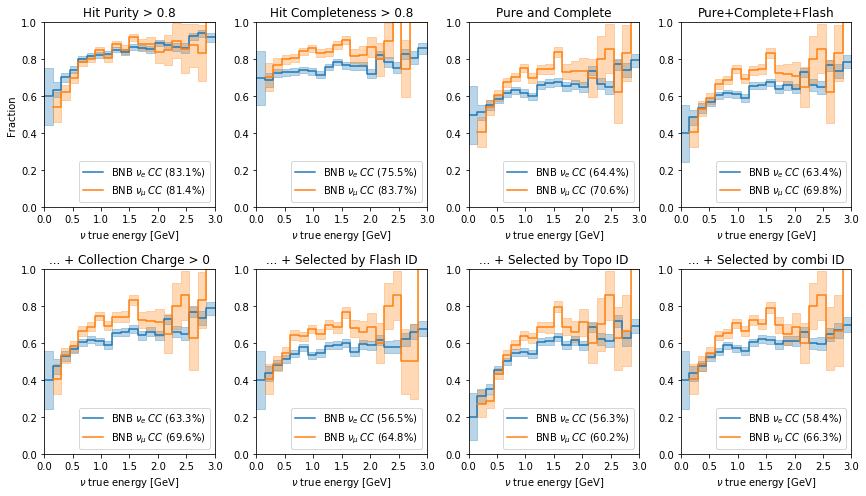

In [29]:
fig,ax=plt.subplots(ncols=4,nrows=2,figsize=(7.5*gr,7))
ax=ax.flatten()
q_arr = [query_pure, query_complete, query_good, query_good_flash, 
         query_perfect, query_perfect_flash_id, query_perfect_topo_id, query_perfect_combi_id]
title_arr = ['Hit Purity > 0.8', 'Hit Completeness > 0.8', 'Pure and Complete', 'Pure+Complete+Flash', 
             '... + Collection Charge > 0', '... + Selected by Flash ID', '... + Selected by Topo ID', '... + Selected by combi ID']

x_min = 0
x_max = 3
N = 21
edges = np.linspace(x_min,x_max,N)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]
# in the denominator we use the event frames, one entry per event
denom_bins_nue, _ = np.histogram(df_nue_sig['nuEnergy'], bins=edges)
denom_bins_nu, _ = np.histogram(df_nu_sig['nuEnergy'], bins=edges)

for i,(query, title) in enumerate(zip(q_arr, title_arr)):
    #nue
    nom_bins, _ = np.histogram(df_nue_slices_sig.query(query).drop_duplicates(['evt_time_nsec'])['nuEnergy'], bins=edges)
    fraq = nom_bins/denom_bins_nue
    ratio = sum(nom_bins)/sum(denom_bins_nue)
    err = np.sqrt( fraq*(1-fraq)/denom_bins_nue)
    fraq=np.append(fraq,fraq[-1])
    err=np.append(err,err[-1])
    ax[i].step(edges, fraq, where='post', label = r'BNB $\nu_e \: CC$ ({0:.1f}%)'.format(ratio*100))
    ax[i].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C0')
    #nu
    nom_bins, _ = np.histogram(df_nu_slices_sig.query(query).drop_duplicates(['evt_time_nsec'])['nuEnergy'], bins=edges)
    fraq = nom_bins/denom_bins_nu
    ratio = sum(nom_bins)/sum(denom_bins_nu)
    err = np.sqrt( fraq*(1-fraq)/denom_bins_nu)
    fraq=np.append(fraq,fraq[-1])
    err=np.append(err,err[-1])
    ax[i].step(edges, fraq, where='post', label = r'BNB $\nu_\mu \: CC$ ({0:.1f}%)'.format(ratio*100))
    ax[i].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C1')
    ax[i].legend(loc='lower right')
    ax[i].set_xlabel(r'$\nu$ true energy [GeV]')
    ax[i].set_title(title)
    ax[i].set_ylim(0.0,1)
    ax[i].set_xlim(x_min,x_max)
    ax[i].set_xticks(np.linspace(0,3,7))
    
ax[0].set_ylabel('Fraction')
fig.tight_layout()
fig.savefig( outdir+"slice_eff_mc.pdf", bbox_inches="tight")

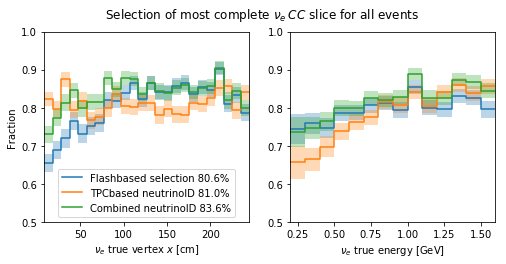

In [30]:
# Make the plot to compare the topological score with the flashbased selection:
x_flash = df_slices_sig.query(query_all_flash_id)['nuVertexX']
x_topo = df_slices_sig.query(query_all_topo_id)['nuVertexX']
x_combi = df_slices_sig.query(query_all_combi_id)['nuVertexX']
x_denom = df_slices_sig.query(query_all)['nuVertexX']

E_flash = df_slices_sig.query(query_all_flash_id)['nuEnergy']
E_topo = df_slices_sig.query(query_all_topo_id)['nuEnergy']
E_combi = df_slices_sig.query(query_all_combi_id)['nuEnergy']
E_denom = df_slices_sig.query(query_all)['nuEnergy']

ratio_flash = len(df_slices_sig.query(query_all_flash_id))/len(df_slices_sig.query(query_all))
ratio_topo = len(df_slices_sig.query(query_all_topo_id))/len(df_slices_sig.query(query_all))
ratio_combi = len(df_slices_sig.query(query_all_combi_id))/len(df_slices_sig.query(query_all))

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,3.5))
fig.suptitle(r'Selection of most complete $\nu_e \: CC$ slice for all events')
labels = [
    'Flashbased selection {0:.1f}%'.format(ratio_flash*100),
    'TPCbased neutrinoID {0:.1f}%'.format(ratio_topo*100),
    'Combined neutrinoID {0:.1f}%'.format(ratio_combi*100),
]

# Left
x_min = lower[0]+fidvol_arr[0]
x_max = upper[0]-fidvol_arr[1]
N = 24
data = [x_denom,x_flash,x_topo, x_combi]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1:]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= [np.append(f,f[-1]) for f in fraq]
err = [np.append(e,e[-1]) for e in err]

for f,e,l in zip(fraq,err,labels):
    ax[0].step(edges, f, where='post', label = l)
    ax[0].fill_between(edges, f - e, f + e, alpha=0.3, step='post')

ax[0].set_xlabel(r'$\nu_e$ true vertex $x$ [cm]')
ax[0].legend(loc='lower center')
ax[0].set_ylabel('Fraction')
ax[0].set_ylim(0.5,1)
ax[0].set_xlim(x_min, x_max)

# Right
x_min = 0.2
x_max = 1.6
N = 14
data = [E_denom,E_flash,E_topo, E_combi]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1:]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= [np.append(f,f[-1]) for f in fraq]
err = [np.append(e,e[-1]) for e in err]

for f,e,l in zip(fraq,err,labels):
    ax[1].step(edges, f, where='post', label = l)
    ax[1].fill_between(edges, f - e, f + e, alpha=0.3, step='post')
    
ax[1].set_xlabel(r'$\nu_e$ true energy [GeV]')
ax[1].set_ylim(0.5,1)
#ax[1].set_xticks(np.linspace(x_min,x_max,7))
ax[1].set_xlim(x_min, x_max)
#ax[1].set_xticks([0.1,0.5,1,1.5,2,2.5,3])

fig.savefig( outdir+"ID_all.pdf", bbox_inches="tight")

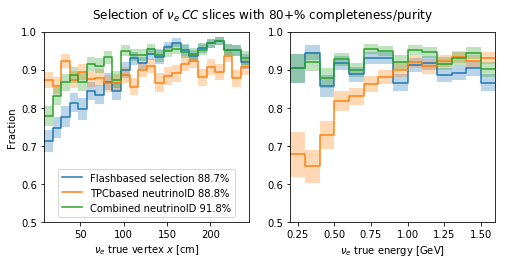

In [31]:
# Make the plot to compare the topological score with the flashbased selection:
x_flash = df_slices_sig.query(query_perfect_flash_id)['nuVertexX']
x_topo = df_slices_sig.query(query_perfect_topo_id)['nuVertexX']
x_combi = df_slices_sig.query(query_perfect_combi_id)['nuVertexX']
x_denom = df_slices_sig.query(query_perfect)['nuVertexX']

E_flash = df_slices_sig.query(query_perfect_flash_id)['nuEnergy']
E_topo = df_slices_sig.query(query_perfect_topo_id)['nuEnergy']
E_combi = df_slices_sig.query(query_perfect_combi_id)['nuEnergy']
E_denom = df_slices_sig.query(query_perfect)['nuEnergy']

ratio_flash = len(df_slices_sig.query(query_perfect_flash_id))/len(df_slices_sig.query(query_perfect))
ratio_topo = len(df_slices_sig.query(query_perfect_topo_id))/len(df_slices_sig.query(query_perfect))
ratio_combi = len(df_slices_sig.query(query_perfect_combi_id))/len(df_slices_sig.query(query_perfect))

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,3.5))
fig.suptitle(r'Selection of $\nu_{e} \: CC$ slices with 80+% completeness/purity')
labels = [
    'Flashbased selection {0:.1f}%'.format(ratio_flash*100),
    'TPCbased neutrinoID {0:.1f}%'.format(ratio_topo*100),
    'Combined neutrinoID {0:.1f}%'.format(ratio_combi*100),
]

# Left
x_min = lower[0]+fidvol_arr[0]
x_max = upper[0]-fidvol_arr[1]
N = 24
data = [x_denom,x_flash,x_topo, x_combi]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1:]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= [np.append(f,f[-1]) for f in fraq]
err = [np.append(e,e[-1]) for e in err]

for f,e,l in zip(fraq,err,labels):
    ax[0].step(edges, f, where='post', label = l)
    ax[0].fill_between(edges, f - e, f + e, alpha=0.3, step='post')

ax[0].set_xlabel(r'$\nu_{e}$ true vertex $x$ [cm]')
ax[0].legend(loc='lower center')
ax[0].set_ylabel('Fraction')
ax[0].set_ylim(0.5,1)
ax[0].set_xlim(x_min, x_max)

# Right
x_min = 0.2
x_max = 1.6
N = 14
data = [E_denom,E_flash,E_topo, E_combi]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1:]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= [np.append(f,f[-1]) for f in fraq]
err = [np.append(e,e[-1]) for e in err]

for f,e,l in zip(fraq,err,labels):
    ax[1].step(edges, f, where='post', label = l)
    ax[1].fill_between(edges, f - e, f + e, alpha=0.3, step='post')
    
ax[1].set_xlabel(r'$\nu_{e}$ true energy [GeV]')
ax[1].set_ylim(0.5,1)
#ax[1].set_xticks(np.linspace(x_min,x_max,7))
ax[1].set_xlim(x_min, x_max)
#ax[1].set_xticks([0.1,0.5,1,1.5,2,2.5,3])

fig.savefig( outdir+"ID_perfect.pdf", bbox_inches="tight")

## Plots

In [32]:
# Plots 
plot_fields_bin = ['deltaZ', 'deltaZSigma', 'deltaY', 'deltaYSigma', 'xclVariable', 'topologicalScore','flashMatchScore']
plot_x_axis = [r"Charge $z$ - Flash $z$ [cm]", "(Charge $z$ - Flash $z$) / Flashwidth $z$",
               r"Charge $y$ - Flash $y$ [cm]", "(Charge $y$ - Flash $y$) / Flashwidth $y$",
               r"m$\cdot\log(\frac{Charge \: [ADC]}{Light \: [PE]})$ - Charge $x$ [cm]", 
               "Topological slice score", r"Flashmatch $\chi^2$"]

x_min_arr =  [-200, -1.8, -120, -4.0, -400, 0, 0]
x_max_arr =  [150,   1.4,  120,  4.0,  600, 1, 100]
bins_arr =   [ 30,    30,   30,   30,   30, 30, 30]
cut_arr =    [115,  1.0,    95, 2.3,[100,400], 0, 0]

# Define what a bad slice is
query_bad = query_has_flash+' & '+query_has_deposition+' & (purity<0.2) & (completeness<0.2)'

1.1146457806648695
Signal kept:	 0.9859750240153698
BG rejected:	 0.8206566814655804
1.1108464073078457
Signal kept:	 0.9840537944284342
BG rejected:	 0.7978728594428453
1.1189578211444686
Signal kept:	 0.9798270893371758
BG rejected:	 0.18251451431916865
1.116818447322801
Signal kept:	 0.9796349663784822
BG rejected:	 0.13240962092013464
1.1303767941312295
Signal kept:	 0.9704130643611911
BG rejected:	 0.42542811143094106
1.067595168662675
1.195131496320952


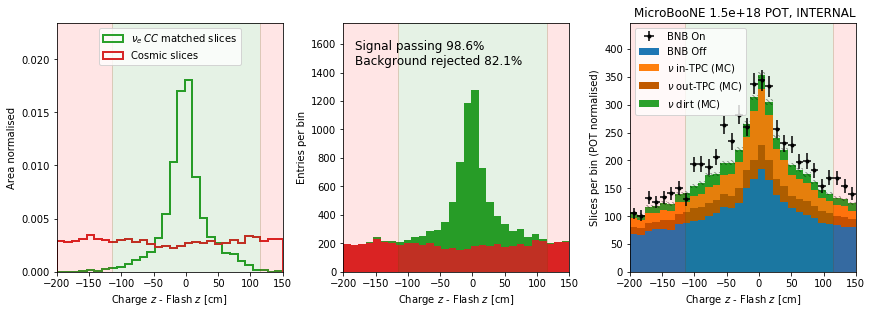

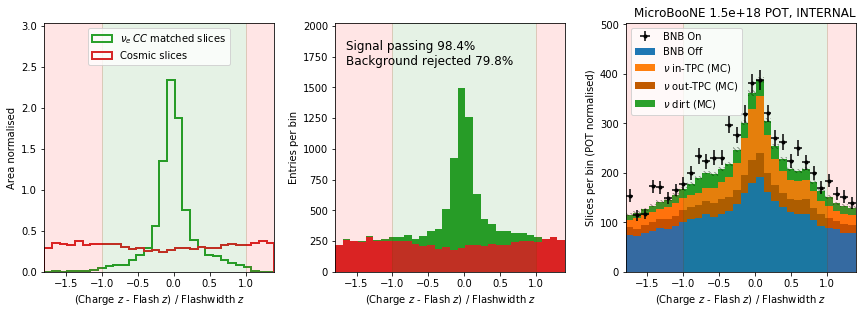

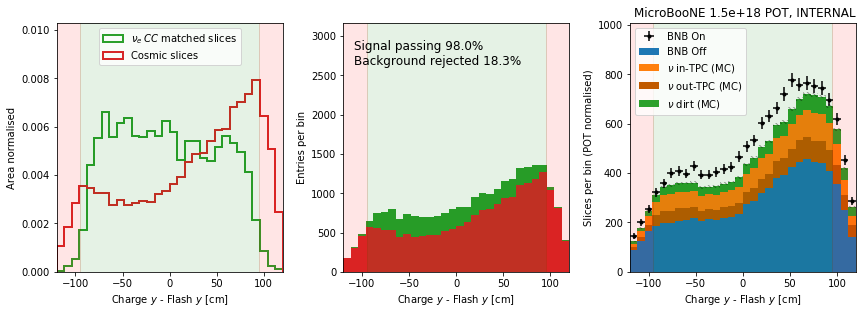

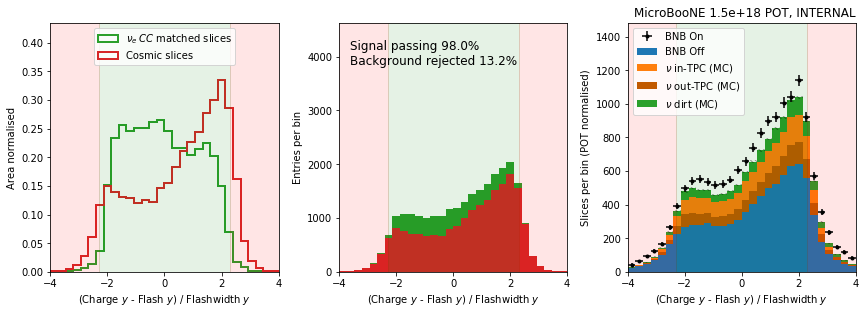

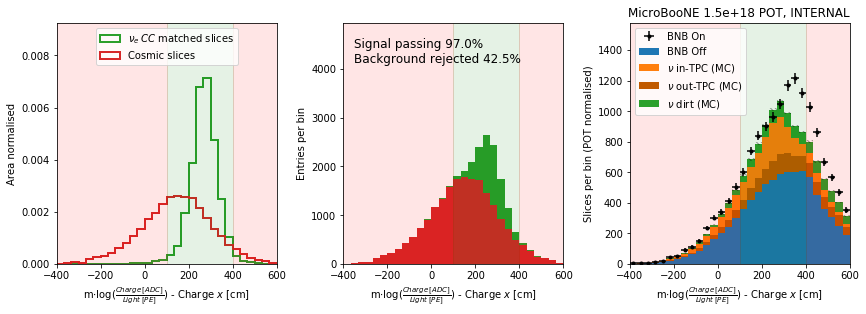

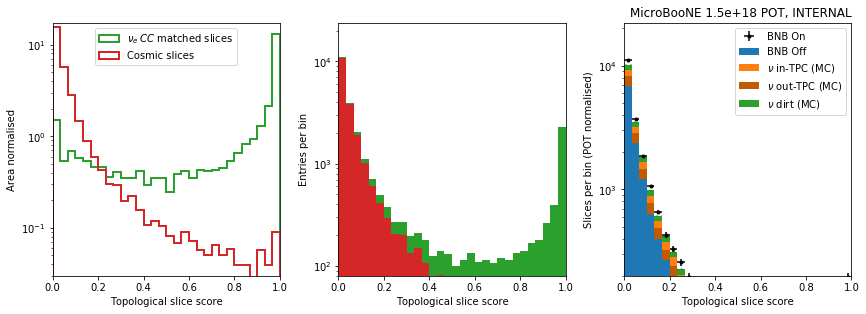

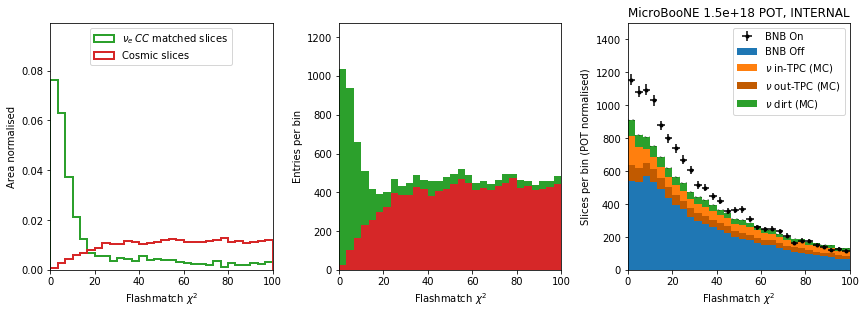

In [33]:
# Plotter
labels = ['Cosmic slices', r'$\nu_e \: CC$ matched slices']

for field ,x_axis, x_min, x_max, bins, cut in zip(plot_fields_bin, plot_x_axis, x_min_arr, x_max_arr, bins_arr, cut_arr):
    fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7.5*gr,4.5), sharex=True)
    
    data_good = df_slices_sig.query(query_perfect)[field]
    data_bad = df_slices_sig.query(query_bad)[field]
    data = [data_bad,data_good]
    
    edges = np.linspace(x_min,x_max, bins+1)
    n,_,_ = ax[0].hist(data, bins=edges, label=labels, histtype='step', lw=2, density=1, color=['C3','C2'])
    m,_,_ = ax[1].hist(data, bins=edges, label=labels, histtype='barstacked', color=['C3','C2'])
    
    max_y0 = max(max(n[1]), max(n[0]))
    max_y1 = max(np.array(m[1])+np.array(m[0]))
    
    ax[0].set_xlabel(x_axis)
    ax[1].set_xlabel(x_axis)
    ax[1].set_ylabel('Entries per bin')
    ax[0].set_ylabel('Area normalised')
    ax[0].legend(loc='upper center')
    ax[0].set_ylim(0,1.3*max_y0)
    ax[1].set_ylim(0,1.2*max_y1)
    ax[0].set_xlim(x_min,x_max)
    
    # Data/MC part of the plot
    ax[2].set_ylabel('Slices per bin (POT normalised)')
    data = [file_dict[s]['slices'].array(field) for s in dict_names]
    data.append(data[1][~mask_nu_slices])
    scales_here = scales+[scales[1]]
    edges, edges_mid, bins, err, max_val = helper.histHelper(bins,x_min,x_max,data, weights=scales_here)
    widths = (edges_mid - edges[:-1])

    ax[2].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On")
    ax[2].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
    ax[2].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ in-TPC (MC)', width = 2*widths, bottom = bins[3])
    ax[2].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
    ax[2].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])
    y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
    val = bins[3]+bins[1]+bins[4]
    for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
        ax[2].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))

    ax[2].set_xlabel(x_axis)
    ax[2].set_ylim(0,1.3*max_val[2])
    ax[2].legend()
    
    print( sum(bins[2])/(sum(bins[1])+sum(bins[3])+sum(bins[4])))

    # Precuts
    if isinstance(cut, list):
        #Ratio of good slices kept by this cut:
        mask_cut = (data_good>cut[0]) & (data_good<cut[1])
        ratio_kept = sum(mask_cut)/len(mask_cut) 
        print("Signal kept:\t",ratio_kept)
        mask_cut = (data_bad>cut[0]) & (data_bad<cut[1])
        ratio_bg = sum(mask_cut)/len(mask_cut) 
        print("BG rejected:\t",1-ratio_bg)
            
        text_x = x_min+(x_max-x_min)*0.05
        ax[1].text(text_x, max_y1, 'Signal passing {0:.1f}%\nBackground rejected {1:.1f}%'.format(ratio_kept*100,100-ratio_bg*100), fontsize=12)
        
        for ax_i in ax:
            ax_i.axvspan(x_min,cut[0], alpha=0.1, color="red")
            ax_i.axvspan(cut[0],cut[1], alpha=0.1, color="green")
            ax_i.axvspan(cut[1],x_max, alpha=0.1, color="red")
        
    elif cut!=0:
        #Ratio of good slices kept by this cut:
        mask_cut = (data_good>-cut) & (data_good<cut)
        ratio_kept = sum(mask_cut)/len(mask_cut) 
        print("Signal kept:\t",ratio_kept)
        mask_cut = (data_bad>-cut) & (data_bad<cut)
        ratio_bg = sum(mask_cut)/len(mask_cut) 
        print("BG rejected:\t",1-ratio_bg)

        text_x = x_min+(x_max-x_min)*0.05
        ax[1].text(text_x, max_y1, 'Signal passing {0:.1f}%\nBackground rejected {1:.1f}%'.format(ratio_kept*100,100-ratio_bg*100), fontsize=12)
        for ax_i in ax:
            ax_i.axvspan(x_min,-cut, alpha=0.1, color="red")
            ax_i.axvspan(-cut,cut, alpha=0.1, color="green")
            ax_i.axvspan(cut,x_max, alpha=0.1, color="red")
            
    # Topological score
    if field == "topologicalScore":
        ax[0].set_ylim(0.03,max_y0*1.1)
        ax[1].set_ylim(80,max_y1*1.1)
        ax[2].set_ylim(200,2*max_val[2])
        for ax_i in ax:
            ax_i.set_yscale("log", nonposy='clip') 
    
    ax[2].set_title(title_str,loc='Right')
    fig.tight_layout()
    fig.subplots_adjust(top=0.91)
    fig.savefig( outdir+field+".pdf")

1.0149498884250447
1.054575768507227


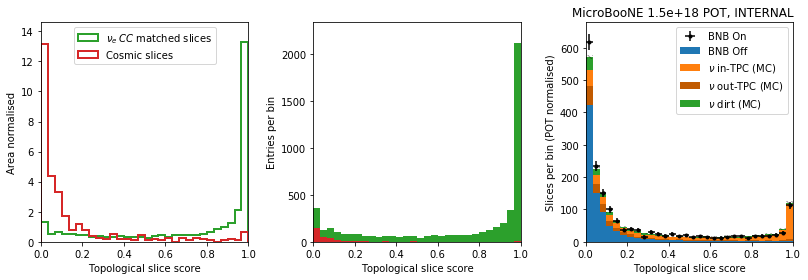

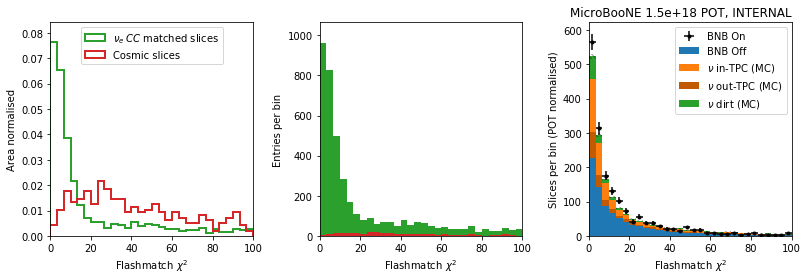

In [34]:
# Plots 
plot_fields_bin = ['topologicalScore','flashMatchScore']
plot_x_axis = ["Topological slice score", r"Flashmatch $\chi^2$"]

x_min_arr =  [0, 0]
x_max_arr =  [1, 100]
bins_arr =   [30, 30]

# Define what a bad slice is
query_bad = query_has_flash+' & '+query_has_deposition+' & (purity<0.2) & (completeness<0.2)'

# Plotter
labels = ['Cosmic slices', r'$\nu_e \: CC$ matched slices']

for field ,x_axis, x_min, x_max, bins in zip(plot_fields_bin, plot_x_axis, x_min_arr, x_max_arr, bins_arr):
    fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7*gr,4), sharex=True)
    
    data_good = df_slices_sig.query(query_perfect+" & + isTaggedAsTarget")[field]
    data_bad = df_slices_sig.query(query_bad+" & + isTaggedAsTarget")[field]
    data = [data_bad,data_good]
    
    edges = np.linspace(x_min,x_max, bins+1)
    n,_,_ = ax[0].hist(data, bins=edges, label=labels, histtype='step', lw=2, density=1, color=['C3','C2'])
    m,_,_ = ax[1].hist(data, bins=edges, label=labels, histtype='barstacked', color=['C3','C2'])
    
    max_y0 = max(max(n[1]), max(n[0]))
    max_y1 = max(np.array(m[1])+np.array(m[0]))
    
    ax[0].set_xlabel(x_axis)
    ax[1].set_xlabel(x_axis)
    ax[1].set_ylabel('Entries per bin')
    ax[0].set_ylabel('Area normalised')
    ax[0].legend(loc='upper center')
    ax[0].set_ylim(0,1.1*max_y0)
    ax[1].set_ylim(0,1.1*max_y1)
    ax[0].set_xlim(x_min,x_max)
    
    # Data/MC part of the plot
    ax[2].set_ylabel('Slices per bin (POT normalised)')
    
    masks = [file_dict[s]['slices'].array('isTaggedAsTarget') for s in dict_names]
    data = [file_dict[s]['slices'].array(field)[m] for s,m in zip(dict_names, masks)]
    data.append(data[1][~mask_nu_slices[masks[1]]])
    scales_here = scales+[scales[1]]
    edges, edges_mid, bins, err, max_val = helper.histHelper(bins,x_min,x_max,data, weights=scales_here)
    widths = (edges_mid - edges[:-1])

    ax[2].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On")
    ax[2].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
    ax[2].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ in-TPC (MC)', width = 2*widths, bottom = bins[3])
    ax[2].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
    ax[2].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])
    y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
    val = bins[3]+bins[1]+bins[4]
    for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
        ax[2].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))

    ax[2].set_xlabel(x_axis)
    ax[2].set_ylim(0,1.1*max_val[2])
    ax[2].legend()
    ax[2].set_title(title_str,loc='Right')
    
    print( sum(bins[2])/(sum(bins[1])+sum(bins[3])+sum(bins[4])))
    
    fig.tight_layout()
    fig.savefig( outdir+field+"_afterselection.pdf")

0.9939014248586722


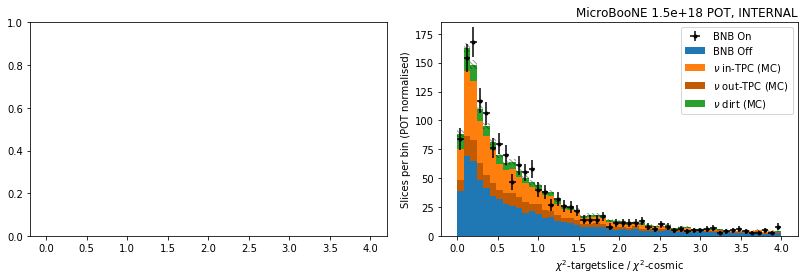

In [35]:
# We try to plot the chi2-ratio

# Plotter
labels = ['Cosmic slices', r'$\nu_e \: CC$ matched slices']
field = 'flashMatchScore'
x_min = 0
x_max = 4
x_axis = r'$\chi^2$-targetslice / $\chi^2$-cosmic'
bins=50

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(7*gr,4), sharex=True)

# Data/MC part of the plot
mask_s = [file_dict[s]['slices'].array('isTaggedAsTarget') for s in dict_names]
mask_e = [file_dict[s]['events'].array('foundATargetSlice') for s in dict_names]
data = [file_dict[s]['slices'].array(field)[m_s]/file_dict[s]['events'].array('bestCosmicMatch')[m_e] for s,m_s,m_e in zip(dict_names, mask_s, mask_e)]
data.append(data[1][~mask_nu_slices[masks[1]]])
scales_here = scales+[scales[1]]
edges, edges_mid, bins, err, max_val = helper.histHelper(bins,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])

ax[1].set_ylabel('Slices per bin (POT normalised)')
ax[1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On")
ax[1].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
ax[1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ in-TPC (MC)', width = 2*widths, bottom = bins[3])
ax[1].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[1].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])
y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))

ax[1].set_xlabel(x_axis)
ax[1].set_ylim(0,1.1*max_val[2])
ax[1].legend()
ax[1].set_title(title_str,loc='Right')

print( sum(bins[2])/(sum(bins[1])+sum(bins[3])+sum(bins[4])))

fig.tight_layout()
fig.savefig( outdir+"chi2ratio_afterselection.pdf")

In [36]:
sum(df_slices_sig.query(query_perfect+" & + passesPreCuts")["flashMatchScore"]<100)/len(df_slices_sig.query(query_perfect+" & + passesPreCuts"))

0.7868072787427626

In [37]:
# How much of the perfect slices is passing the precuts?
df_perfect_slices = df_slices_sig.query(query_perfect).copy()
print(df_perfect_slices['passesPreCuts'].value_counts()/len(df_perfect_slices)*100)
# How much of the mostcomplete slices is passing the precuts?
df_comp_slices = df_slices_sig.query(query_all).copy()
print(df_comp_slices['passesPreCuts'].value_counts()/len(df_comp_slices)*100)

True     92.910663
False     7.089337
Name: passesPreCuts, dtype: float64
True     85.463043
False    14.536957
Name: passesPreCuts, dtype: float64


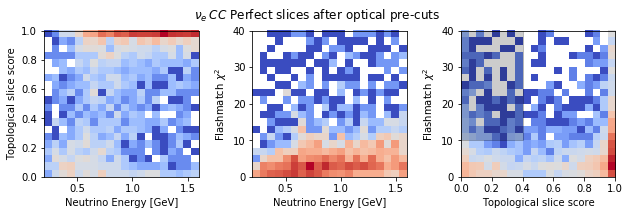

In [38]:
# Make 2D plots of chi2 and topo after selection ifo nuenergy:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(5.5*gr,3))

df_view = df_slices_sig.query(query_perfect+" & + passesPreCuts")
sig_E = df_view['nuEnergy']
sig_chi2 = df_view['topologicalScore']
sig_topo = df_view['flashMatchScore']
plot_data = [sig_E, sig_chi2, sig_topo]
plot_labs = ["Neutrino Energy [GeV]", "Topological slice score", r"Flashmatch $\chi^2$"]
plot_min = [0.2,0,0]
plot_max = [1.6,1,40]

for i,(j,k) in enumerate([(0,1),(0,2),(1,2)]):
    ax[i].hist2d(plot_data[j],plot_data[k], 
                 cmap='coolwarm', range =  [[plot_min[j], plot_max[j]], [plot_min[k], plot_max[k]]], 
                 bins = [20,20], norm=colors.LogNorm())
    ax[i].set_xlabel(plot_labs[j])
    ax[i].set_ylabel(plot_labs[k])

ax[2].add_patch(patches.Rectangle( (0, 10), 0.4, 40, alpha=0.2, color='k'))
fig.suptitle(r'$\nu_e \: CC$ Perfect slices after optical pre-cuts')
fig.tight_layout()
fig.subplots_adjust(top=0.87)
fig.savefig(outdir+"2d_topo_chi2.pdf")

## Tuning the cuts

In [39]:
#len
ns_sig = len(df_slices_sig)/100 
ns_comp = num_sig/100
ns_off = file_dict['off']['slices'].numentries/100

In [40]:
default = False
if default:
    CoefXCL=                  190
    MaxDeltaY=                95.0
    MaxDeltaZ=                105.0
    MaxDeltaYSigma=           2.1 
    MaxDeltaZSigma=           1.0
    MinChargeToLightRatio=    50
    MaxChargeToLightRatio=    250
    TopologicalCut=           0.  
else:
    CoefXCL=                  270
    MaxDeltaY=                95.0
    MaxDeltaZ=                115.0
    MaxDeltaYSigma=           2.3 
    MaxDeltaZSigma=           1.0
    MinChargeToLightRatio=    100
    MaxChargeToLightRatio=    400
    TopologicalCut=           0.00

In [41]:
#flash
mask_f1 = df_slices_sig['isConsideredByFlashId']
mask_f2 = df_slices_sig.query('isMostComplete')['isConsideredByFlashId']
mask_f3 = file_dict['off']['slices'].array('isConsideredByFlashId')
print("f-cut\nsig:\t\t{0:.1f}%\ncomplete:\t{1:.1f}%\noff:\t\t{2:.1f}%".format(sum(mask_f1)/ns_sig, sum(mask_f2)/ns_comp, sum(mask_f3)/ns_off))

f-cut
sig:		98.3%
complete:	98.4%
off:		68.1%


In [42]:
#charge
mask_q1 = df_slices_sig['hasDeposition']
mask_q2 = df_slices_sig.query('isMostComplete')['hasDeposition']
mask_q3 = file_dict['off']['slices'].array('hasDeposition')
print("q-cut\nsig:\t\t{0:.1f}%\ncomplete:\t{1:.1f}%\noff:\t\t{2:.1f}%".format(sum(mask_q1)/ns_sig, sum(mask_q2)/ns_comp, sum(mask_q3)/ns_off))

q-cut
sig:		97.6%
complete:	99.4%
off:		96.3%


In [43]:
#z:
mask_z1 = df_slices_sig['deltaZ'].between(-MaxDeltaZ,MaxDeltaZ)
mask_z2 = df_slices_sig.query('isMostComplete')['deltaZ'].between(-MaxDeltaZ,MaxDeltaZ)
t = file_dict['off']['slices'].array('deltaZ')
mask_z3 = (-MaxDeltaZ <t) & (t< MaxDeltaZ)
print("z-cut\nsig:\t\t{0:.1f}%\ncomplete:\t{1:.1f}%\noff:\t\t{2:.1f}%".format(sum(mask_z1)/ns_sig, sum(mask_z2)/ns_comp, sum(mask_z3)/ns_off))

z-cut
sig:		39.1%
complete:	94.1%
off:		17.9%


In [44]:
#zs:
mask_zs1 = df_slices_sig['deltaZSigma'].between(-MaxDeltaZSigma,MaxDeltaZSigma)
mask_zs2 = df_slices_sig.query('isMostComplete')['deltaZSigma'].between(-MaxDeltaZSigma,MaxDeltaZSigma)
t = file_dict['off']['slices'].array('deltaZSigma')
mask_zs3 = (-MaxDeltaZSigma <t) & (t< MaxDeltaZSigma)
print("zs-cut\nsig:\t\t{0:.1f}%\ncomplete:\t{1:.1f}%\noff:\t\t{2:.1f}%".format(sum(mask_zs1)/ns_sig, sum(mask_zs2)/ns_comp, sum(mask_zs3)/ns_off))

zs-cut
sig:		40.7%
complete:	94.2%
off:		18.5%


In [45]:
#y:
mask_y1 = df_slices_sig['deltaY'].between(-MaxDeltaY,MaxDeltaY)
mask_y2 = df_slices_sig.query('isMostComplete')['deltaY'].between(-MaxDeltaY,MaxDeltaY)
t = file_dict['off']['slices'].array('deltaY')
mask_y3 = (-MaxDeltaY <t) & (t< MaxDeltaY)
print("y-cut\nsig:\t\t{0:.1f}%\ncomplete:\t{1:.1f}%\noff:\t\t{2:.1f}%".format(sum(mask_y1)/ns_sig, sum(mask_y2)/ns_comp, sum(mask_y3)/ns_off))

y-cut
sig:		82.8%
complete:	95.9%
off:		54.2%


In [46]:
#ys:
mask_ys1 = df_slices_sig['deltaYSigma'].between(-MaxDeltaYSigma,MaxDeltaYSigma)
mask_ys2 = df_slices_sig.query('isMostComplete')['deltaYSigma'].between(-MaxDeltaYSigma,MaxDeltaYSigma)
t = file_dict['off']['slices'].array('deltaYSigma')
mask_ys3 = (-MaxDeltaYSigma <t) & (t< MaxDeltaYSigma)
print("ys-cut\nsig:\t\t{0:.1f}%\ncomplete:\t{1:.1f}%\noff:\t\t{2:.1f}%".format(sum(mask_ys1)/ns_sig, sum(mask_ys2)/ns_comp, sum(mask_ys3)/ns_off))

ys-cut
sig:		86.3%
complete:	96.1%
off:		52.6%


In [47]:
#topo:
mask_t1 = df_slices_sig['topologicalScore']>TopologicalCut
mask_t2 = df_slices_sig.query('isMostComplete')['topologicalScore']>TopologicalCut
t = file_dict['off']['slices'].array('topologicalScore')
mask_t3 = (TopologicalCut <t) 
print("t-cut\nsig:\t\t{0:.1f}%\ncomplete:\t{1:.1f}%\noff:\t\t{2:.1f}%".format(sum(mask_t1)/ns_sig, sum(mask_t2)/ns_comp, sum(mask_t3)/ns_off))

t-cut
sig:		95.4%
complete:	95.7%
off:		94.6%


In [48]:
#xcl:
mask_xcl1 = (CoefXCL*np.log10(df_slices_sig['chargeToLightRatio'])-df_slices_sig['centerX']).between(-MinChargeToLightRatio,MaxChargeToLightRatio)
mask_xcl2 = (CoefXCL*np.log10(df_slices_sig.query('isMostComplete')['chargeToLightRatio'])-df_slices_sig.query('isMostComplete')['centerX']).between(-MinChargeToLightRatio,MaxChargeToLightRatio)
t = file_dict['off']['slices'].array('deltaY')
mask_xcl3 = (-MaxDeltaY <t) & (t< MaxDeltaY)
print("y-cut\nsig:\t\t{0:.1f}%\ncomplete:\t{1:.1f}%\noff:\t\t{2:.1f}%".format(sum(mask_xcl1)/ns_sig, sum(mask_xcl2)/ns_comp, sum(mask_xcl3)/ns_off))

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


y-cut
sig:		86.6%
complete:	94.9%
off:		54.2%


In [49]:
# combined:
pass1 = mask_f1 & mask_q1 & mask_z1 & mask_zs1 & mask_y1 & mask_ys1 & mask_xcl1 & mask_t1
pass2 = mask_f2 & mask_q2 & mask_z2 & mask_zs2 & mask_y2 & mask_ys2 & mask_xcl2 & mask_t2
pass3 = mask_f3 & mask_q3 & mask_z3 & mask_zs3 & mask_y3 & mask_ys3 & mask_xcl3 & mask_t3

print("passing rates:\nsig:\t\t{0:.1f}%\ncomplete:\t{1:.1f}%\noff:\t\t{2:.1f}%".format(sum(pass1)/ns_sig, sum(pass2)/ns_comp, sum(pass3)/ns_off))

passing rates:
sig:		32.0%
complete:	85.4%
off:		12.7%


In [50]:
# and for good slices?
len(df_slices_sig[pass1].query(query_perfect))/len(df_perfect_slices)*100

91.50816522574448

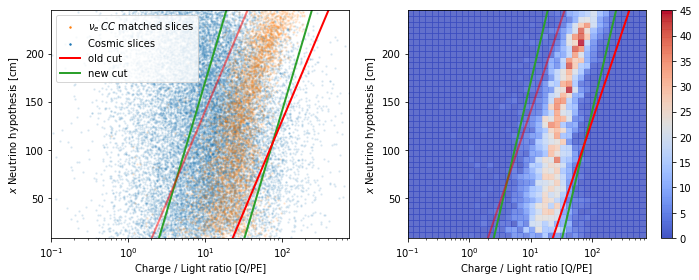

In [51]:
labels = ['Cosmic slices', r'$\nu_e \: CC$ matched slices']

# Scatterplot to see xdependence on the charge light ratio!
N=1000000
m_xcl = 270
m_xcl_old = 190

field = 'chargeToLightRatio'
x_good = df_slices_sig.query(query_perfect)[field].head(N)
x_bad = df_slices_sig.query(query_bad)[field].head(N)
x_data = [x_bad, x_good]
x_max = 750
x_min = 0.1
x_bins = 40
x_edges=np.logspace(np.log10(x_min),np.log10(x_max), x_bins)

field = 'centerX'
y_good = df_slices_sig.query(query_perfect)[field].head(N)
y_bad = df_slices_sig.query(query_bad)[field].head(N)
y_data = [y_bad, y_good]
y_max = upper[0]-fidvol_arr[0]
y_min = lower[0]+fidvol_arr[1]
y_bins = 40
y_edges=np.linspace(y_min,y_max, y_bins)

fig, ax = plt.subplots(ncols = 2, sharex=False, sharey = False, figsize=(10,4))
for x_arr, y_arr, lab in zip(x_data, y_data, labels):
    ax[0].scatter(x_arr, y_arr, s=2, alpha=0.1, label=lab)

mids_x = 0.5*(x_edges[1:] + x_edges[:-1])
ax[0].plot(mids_x, m_xcl*np.log10(mids_x)-100, color='C2', lw=2, label='new cut')
ax[0].plot(mids_x, m_xcl*np.log10(mids_x)-400, color='C2', lw=2)

ax[0].plot(mids_x, m_xcl_old*np.log10(mids_x)-50, color='r', lw=2, label='old cut', alpha=0.5)
ax[0].plot(mids_x, m_xcl_old*np.log10(mids_x)-250, color='r', lw=2)

handles, labels = ax[0].get_legend_handles_labels()
leg=ax[0].legend(handles[::-1], labels[::-1],loc="upper left")
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax[0].set_xscale("log", nonposx='clip') 
ax[0].set_xlim(x_min,x_max)

ax[0].set_xlabel("Charge / Light ratio [Q/PE]")
ax[1].set_xlabel("Charge / Light ratio [Q/PE]")
ax[0].set_ylabel(r"$x$ Neutrino hypothesis [cm]")
ax[1].set_ylabel(r"$x$ Neutrino hypothesis [cm]")

h,_,_ = np.histogram2d(x_good,y_good, bins=(x_edges,y_edges))
X, Y = np.meshgrid(x_edges, y_edges)
im = ax[1].pcolormesh(X, Y, h.T, cmap='coolwarm', alpha=0.8)
clb = fig.colorbar(im, ax=ax[1])
ax[1].set_xscale('log')
ax[0].set_ylim(y_min, y_max)
ax[1].set_ylim(y_min, y_max)

ax[1].plot(mids_x, m_xcl*np.log10(mids_x)-100, color='C2', lw=2, label='new cut')
ax[1].plot(mids_x, m_xcl*np.log10(mids_x)-400, color='C2', lw=2)

ax[1].plot(mids_x, m_xcl_old*np.log10(mids_x)-50, color='r', lw=2, label='old cut', alpha=0.5)
ax[1].plot(mids_x, m_xcl_old*np.log10(mids_x)-250, color='r', lw=2)

fig.tight_layout()
fig.savefig(outdir+"scatter_x_charge_light.png", bbox_inches="tight", dpi=300)

## Make some slice level Data/MC plots

In [52]:
field_arr = [b'totalCharge', b'centerX', b'centerY', b'centerZ']
N_arr = [25,25,25,25]
x_min_arr = [0,*lower]
x_max_arr = [100000,*upper]
label_arr = ['Total charge per slice', 'Charge position of slice $x$ [cm]', 
             'Charge position of slice $y$ [cm]', 'Charge position of slice $z$ [cm]']
arrays = [field_arr, N_arr, x_min_arr, x_max_arr, label_arr]

20575


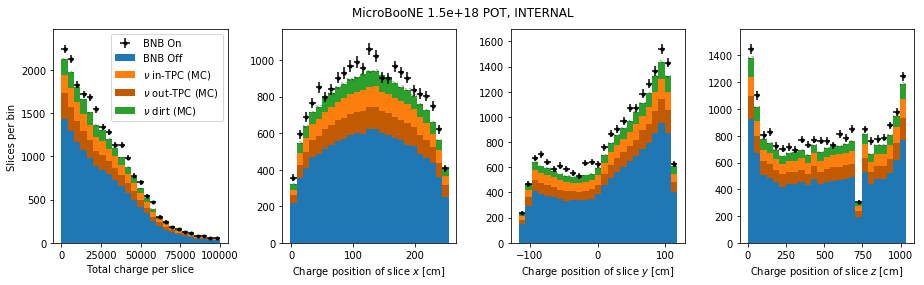

In [53]:
# hits and charge per slice
fig,ax=plt.subplots(ncols=4,nrows=1,figsize=(8*gr,4))
fig.suptitle(title_str)

for i,(field, N, x_min, x_max, lab) in enumerate(zip(*arrays)):
    data = [file_dict[s]['slices'].array(field) for s in dict_names]
    data.append(data[1][~mask_nu_slices])
    scales_here = scales+[scales[1]]
    edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
    widths = (edges_mid - edges[:-1])

    # Data/MC
    ax[i].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On")
    ax[i].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
    ax[i].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ in-TPC (MC)', width = 2*widths, bottom = bins[3])
    ax[i].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')

    ax[i].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])
    y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
    val = bins[3]+bins[1]+bins[4]
    for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
        ax[i].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))

    ax[i].set_xlabel(lab)
    ax[i].set_ylim(0,1.1*max_val[2])

ax[0].legend()
ax[0].set_ylabel('Slices per bin')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.savefig( outdir+"data_mc_slices_charge.pdf", bbox_inches="tight")

print(sum(bins[2]))

1784


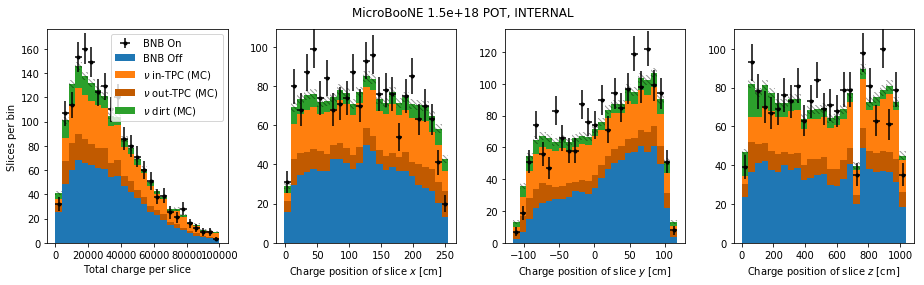

In [54]:
# hits and charge per slice
fig,ax=plt.subplots(ncols=4,nrows=1,figsize=(8*gr,4))
fig.suptitle(title_str)

for i,(field, N, x_min, x_max, lab) in enumerate(zip(*arrays)):
    masks = [file_dict[s]['slices'].array('isTaggedAsTarget') for s in dict_names]
    data = [file_dict[s]['slices'].array(field)[m] for s,m in zip(dict_names, masks)]
    data.append(data[1][~mask_nu_slices[masks[1]]])
    scales_here = scales+[scales[1]]
    edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
    widths = (edges_mid - edges[:-1])

    # Data/MC
    ax[i].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On")
    ax[i].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
    ax[i].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ in-TPC (MC)', width = 2*widths, bottom = bins[3])
    ax[i].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')

    ax[i].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])
    y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
    val = bins[3]+bins[1]+bins[4]
    for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
        ax[i].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))

    ax[i].set_xlabel(lab)
    ax[i].set_ylim(0,1.1*max_val[2])

ax[0].legend()
ax[0].set_ylabel('Slices per bin')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.savefig( outdir+"data_mc_slices_charge_selected.pdf", bbox_inches="tight")

print(sum(bins[2]))

In [55]:
# NUMU these are the hashes of all events that are reconstructed in fidvol
df_event_nu = nuecc_dict['nu']['Event'].pandas.df(['evt_time_sec','evt_time_nsec','nu_vx','nu_vy','nu_vz'])
df_event_nu['hash'] = eventHash(df_event_nu[['evt_time_sec', 'evt_time_nsec']])
df_nu_slices_sig['hash'] = eventHash(df_nu_slices_sig[['evt_time_sec', 'evt_time_nsec']])
nu_hash_reco_fidvol = df_event_nu['hash'][inTPC_mask( df_event_nu, 'nu_vx', 'nu_vy', 'nu_vz', fidvol=fidvol_arr).values]

In [56]:
# NUE these are the hashes of all events that are reconstructed in fidvol
df_event_nue = nuecc_dict['nue']['Event'].pandas.df(['evt_time_sec','evt_time_nsec','nu_vx','nu_vy','nu_vz'])
df_event_nue['hash'] = eventHash(df_event_nue[['evt_time_sec', 'evt_time_nsec']])
df_nue_slices_sig['hash'] = eventHash(df_nue_slices_sig[['evt_time_sec', 'evt_time_nsec']])
nue_hash_reco_fidvol = df_event_nue['hash'][inTPC_mask( df_event_nue, 'nu_vx', 'nu_vy', 'nu_vz', fidvol=fidvol_arr).values]

In [57]:
# OFF these are the hashes of all events that are reconstructed in fidvol
df_event_off = nuecc_dict['off']['Event'].pandas.df(['evt_time_sec','evt_time_nsec','nu_vx','nu_vy','nu_vz'])
df_event_off['hash'] = eventHash(df_event_off[['evt_time_sec', 'evt_time_nsec']])
slices_off_hash = eventHash(file_dict['off']['slices'].pandas.df(['evt_time_sec','evt_time_nsec']))
off_hash_reco_fidvol = df_event_off['hash'][inTPC_mask( df_event_off, 'nu_vx', 'nu_vy', 'nu_vz', fidvol=fidvol_arr).values]

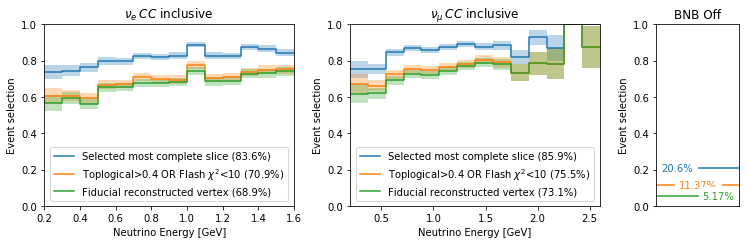

In [58]:
# Show the efficiency and bnb off rejection after applying 2 cuts:
# reco vtx in fid vol
# (chi2<10) | (toposcore<0.4)
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(6.5*gr,3.5), gridspec_kw = {'width_ratios':[3, 3, 1]}, sharey=False)

# Left
E_all = df_nue_slices_sig.query(query_all)['nuEnergy']
E_comp = df_nue_slices_sig.query(query_all+" & isTaggedAsTarget")['nuEnergy']
df_view = df_nue_slices_sig.query(query_all+" & isTaggedAsTarget & (topologicalScore>0.4 | flashMatchScore<10)")
E_cut1 = df_view['nuEnergy']
E_cut2 = df_view[df_view['hash'].isin(nue_hash_reco_fidvol)]['nuEnergy']

num_nue_sig = len(df_nue_sig)
ratio_comp = len(E_comp)/num_nue_sig
ratio_cut1 = len(E_cut1)/num_nue_sig
ratio_cut2 = len(E_cut2)/num_nue_sig
labels = ['Selected most complete slice ({0:.1f}%)'.format(ratio_comp*100),
          'Toplogical>0.4 OR Flash $\chi^2$<10 ({0:.1f}%)'.format(ratio_cut1*100),
          'Fiducial reconstructed vertex ({0:.1f}%)'.format(ratio_cut2*100)]

N = 14
x_min = 0.2
x_max = 1.6
data = [E_all.values,E_comp.values,E_cut1.values, E_cut2.values]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1:]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= [np.append(f,f[-1]) for f in fraq]
err = [np.append(e,e[-1]) for e in err]

for f,e,l in zip(fraq,err,labels):
    ax[0].step(edges, f, where='post', label = l)
    ax[0].fill_between(edges, f - e, f + e, alpha=0.3, step='post')

ax[0].legend(loc='lower center')
ax[0].set_xlabel("Neutrino Energy [GeV]")
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylabel('Event selection')
ax[0].set_ylim(0.0,1)
ax[0].set_title(r"$\nu_e \: CC$ inclusive")

#middle:
E_all = df_nu_slices_sig.query(query_all)['nuEnergy']
E_comp = df_nu_slices_sig.query(query_all+" & isTaggedAsTarget")['nuEnergy']
df_view = df_nu_slices_sig.query(query_all+" & isTaggedAsTarget & (topologicalScore>0.4 | flashMatchScore<10)")
E_cut1 = df_view['nuEnergy']
E_cut2 = df_view[df_view['hash'].isin(nu_hash_reco_fidvol)]['nuEnergy']

num_nu_sig = len(df_nu_sig)
ratio_comp = len(E_comp)/num_nu_sig
ratio_cut1 = len(E_cut1)/num_nu_sig
ratio_cut2 = len(E_cut2)/num_nu_sig
labels = ['Selected most complete slice ({0:.1f}%)'.format(ratio_comp*100),
          'Toplogical>0.4 OR Flash $\chi^2$<10 ({0:.1f}%)'.format(ratio_cut1*100),
          'Fiducial reconstructed vertex ({0:.1f}%)'.format(ratio_cut2*100)]

N = 14
x_min = 0.2
x_max = 2.6
data = [E_all.values,E_comp.values,E_cut1.values, E_cut2.values]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1:]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= [np.append(f,f[-1]) for f in fraq]
err = [np.append(e,e[-1]) for e in err]

for f,e,l in zip(fraq,err,labels):
    ax[1].step(edges, f, where='post', label = l)
    ax[1].fill_between(edges, f - e, f + e, alpha=0.3, step='post')

ax[1].legend(loc='lower center')
ax[1].set_xlabel("Neutrino Energy [GeV]")
ax[1].set_xlim([x_min, x_max])
ax[1].set_ylabel('Event selection')
ax[1].set_ylim(0.0,1)
ax[1].set_title(r"$\nu_\mu \: CC$ inclusive")


#right:
num_off = file_dict['off']['events'].numentries
mask_pass = file_dict['off']['slices'].array('isTaggedAsTarget')
mask_topo = file_dict['off']['slices'].array('topologicalScore')>0.4
mask_chi2 = file_dict['off']['slices'].array('flashMatchScore')<10
num_pass = sum(mask_pass)
num_cut1 = sum(mask_pass & (mask_topo | mask_chi2))
mask_fidvol = slices_off_hash.isin(off_hash_reco_fidvol)
num_cut2 = sum(mask_pass & (mask_topo | mask_chi2) & mask_fidvol)

err_pass = helper.effErr(num_pass,num_off)
err_cut1 = helper.effErr(num_cut1,num_off)
err_cut2 = helper.effErr(num_cut2,num_off)
ax[2].axhline(num_pass/num_off, color='C0', label='{0:.1f}%'.format(num_pass/num_off*100))
ax[2].axhline(num_cut1/num_off, color='C1', label='{0:.2f}%'.format(num_cut1/num_off*100))
ax[2].axhline(num_cut2/num_off, color='C2', label='{0:.2f}%'.format(num_cut2/num_off*100))
#ax[2].set_yscale('log')
ax[2].set_xticks([])
ax[2].set_ylabel('Event selection')
ax[2].set_ylim(0.0,1)
ax[2].set_title('BNB Off')

labelLines(plt.gca().get_lines(), zorder=2.5)

fig.tight_layout()
fig.savefig(outdir+"post_optical.pdf")

8131


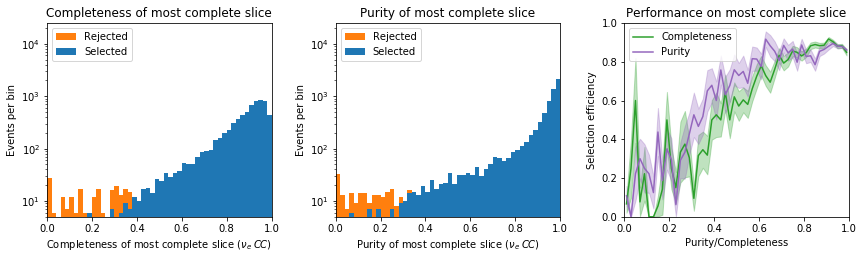

In [59]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7.5*gr,3.7), sharex=True)

m,edges,_= ax[0].hist([df_nue_slices_sig.query("isMostComplete & isTaggedAsTarget")["completeness"], df_nue_slices_sig.query("isMostComplete & ~isTaggedAsTarget")["completeness"]], bins=50, label=['Selected', 'Rejected'], histtype='stepfilled')
n,_,_= ax[1].hist([df_nue_slices_sig.query("isMostComplete & isTaggedAsTarget")["purity"], df_nue_slices_sig.query("isMostComplete & ~isTaggedAsTarget")["purity"]], bins=50, label=['Selected', 'Rejected'], histtype='stepfilled')
print(len(df_nue_slices_sig.query("isMostComplete")["completeness"]))
ax[0].set_xlabel(r"Completeness of most complete slice ($\nu_e \: CC$)")
ax[1].set_xlabel(r"Purity of most complete slice ($\nu_e \: CC$)")
ax[0].legend(loc=2)
ax[0].set_yscale('log')
ax[0].set_ylim(5,25000)
ax[0].set_ylabel(r"Events per bin")
ax[0].set_title('Completeness of most complete slice')

ax[1].legend(loc=2)
ax[1].set_yscale('log')
ax[1].set_ylim(5,25000)
ax[1].set_ylabel(r"Events per bin")
ax[1].set_title('Purity of most complete slice')

ax[2].set_ylim(0,1)
mids=(edges[:-1]+edges[1:])/2
f = m[0]/(m[0]+m[1])
e = helper.effErr(m[0],m[0]+m[1])
ax[2].plot(mids, f, label = 'Completeness', color='C2')
ax[2].fill_between(mids, f - e, f + e, alpha=0.3, color='C2')
f = n[0]/(n[0]+n[1])
e = helper.effErr(n[0],n[0]+n[1])
ax[2].plot(mids, f, label = 'Purity', color='C4')
ax[2].fill_between(mids, f - e, f + e, alpha=0.3, color='C4')
ax[2].set_xlabel(r"Purity/Completeness")
ax[2].set_ylabel(r"Selection efficiency")
ax[2].legend(loc=2)
ax[2].set_xlim(0,1)
ax[2].set_title('Performance on most complete slice')

fig.tight_layout()
fig.savefig( outdir+"selectedpuritycompletness.pdf", bbox_inches="tight")

In [60]:
# Vertex distance in function of purity/completeness:

# NUE these are the hashes of all events that are reconstructed in fidvol
df_event_nue = nuecc_dict['nue']['Event'].pandas.df(['evt_time_sec','evt_time_nsec','mc_nu_vtx_distance'])
df_event_nue['hash'] = eventHash(df_event_nue[['evt_time_sec', 'evt_time_nsec']])
df_nue_slices_sig['hash'] = eventHash(df_nue_slices_sig[['evt_time_sec', 'evt_time_nsec']])
df_nue_slices_sig_selected = df_nue_slices_sig.query('isTaggedAsTarget').copy()
mapper = dict(zip(df_event_nue['hash'],df_event_nue['mc_nu_vtx_distance']))
df_nue_slices_sig_selected['mc_nu_vtx_distance'] = df_nue_slices_sig_selected['hash'].map(mapper)

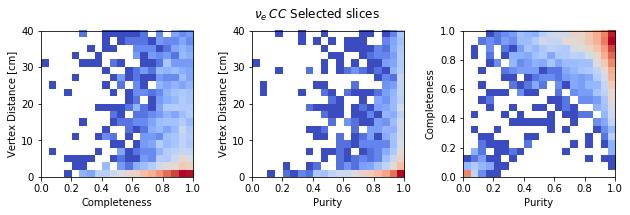

In [61]:
# Make 2D plots of chi2 and topo after selection ifo nuenergy:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(5.5*gr,3))

df_view = df_nue_slices_sig_selected
puri = df_view['purity']
comp = df_view['completeness']
dist = df_view['mc_nu_vtx_distance']
plot_data = [puri, comp, dist]
plot_labs = ["Purity", "Completeness", r"Vertex Distance [cm]"]
plot_min = [0,0,0]
plot_max = [1.,1,40]

for i,(j,k) in enumerate([(1,2),(0,2),(0,1)]):
    ax[i].hist2d(plot_data[j],plot_data[k], 
                 cmap='coolwarm', range =  [[plot_min[j], plot_max[j]], [plot_min[k], plot_max[k]]], 
                 bins = [20,20], norm=colors.LogNorm())
    ax[i].set_xlabel(plot_labs[j])
    ax[i].set_ylabel(plot_labs[k])

fig.suptitle(r'$\nu_e \: CC$ Selected slices')
fig.tight_layout()
fig.subplots_adjust(top=0.87)
fig.savefig(outdir+"2d_puri_comp_dist.pdf")